Self-supervised Transformer for Sparse and Irregularly Sampled multivariate Clinical Time Series

https://arxiv.org/abs/2107.14293

TODO: 
- add seqs with different length and zero_pad appropietly
- add validation set

In [1]:
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

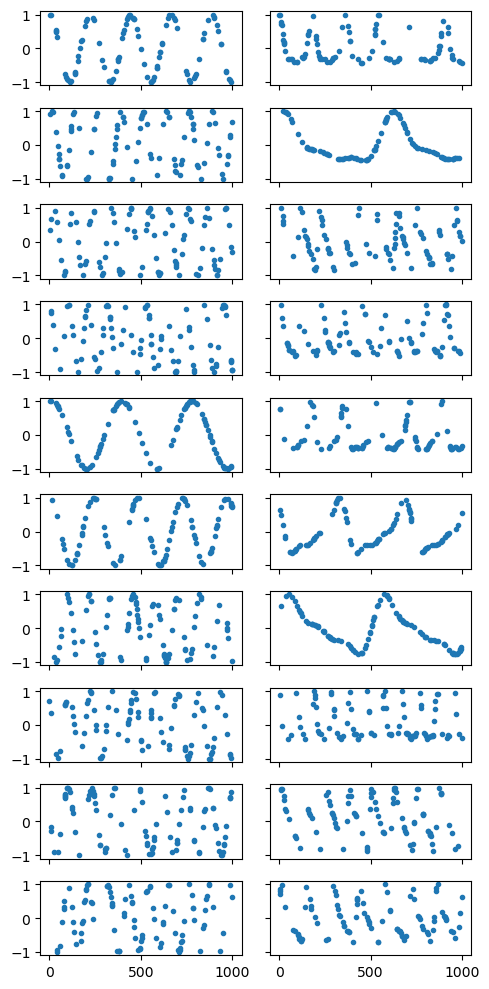

In [2]:
n_lc = 25
n = 100
time_sin = torch.rand(n_lc, n).sort()[0]*1000
freqs = torch.rand(n_lc)*1e-2 +1e-3
phase = torch.pi*torch.rand(n_lc)
flux_sin = torch.sin(2*torch.pi*time_sin*freqs.reshape(-1, 1) + phase.reshape(-1, 1))

time_fs = torch.rand(n_lc, n).sort()[0]*1000
freqs = torch.rand(n_lc)*1e-2 +1e-3
phase = torch.pi*torch.rand(n_lc)
flux_fs = torch.sin(2*torch.pi*time_fs*freqs.reshape(-1, 1) + phase.reshape(-1, 1)) 
flux_fs += 0.5*torch.sin(2*torch.pi*time_fs*2*freqs.reshape(-1, 1) + phase.reshape(-1, 1))
flux_fs += 0.25*torch.sin(2*torch.pi*time_fs*3*freqs.reshape(-1, 1) + phase.reshape(-1, 1))
flux_fs = flux_fs/flux_fs.abs().max(dim=1, keepdim=True)[0]

time = torch.concat([time_sin, time_fs], dim=0)
flux = torch.concat([flux_sin, flux_fs], dim=0)
y = torch.Tensor([0]*n_lc + [1]*n_lc).to(torch.long)

fig, ax = plt.subplots(10, 2, figsize=(5, 10), tight_layout=True, sharex=True, sharey=True)
for time_, flux_, ax_ in zip(time_sin, flux_sin, ax[:, 0]):
    ax_.plot(time_, flux_, '.')
for time_, flux_, ax_ in zip(time_fs, flux_fs, ax[:, 1]):
    ax_.plot(time_, flux_, '.')

In [3]:
from math import sqrt
import torch.nn as nn

def init_glorot(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
        

class ContinuousValueEmbedding(nn.Module):

    def __init__(self, d=32):
        super().__init__()
        hidden_dim = int(sqrt(d))
        self.t_emb = nn.Sequential(nn.Linear(1, hidden_dim), nn.Tanh(), 
                                   nn.Linear(hidden_dim, d, bias=False))
        self.v_emb = nn.Sequential(nn.Linear(1, hidden_dim), nn.Tanh(), 
                                   nn.Linear(hidden_dim, d, bias=False))

        self.t_emb.apply(init_glorot)
        self.v_emb.apply(init_glorot)

    def forward(self, time, value): # (batch_size x seq_len), (batch_size x seq_len)
        et = self.t_emb(time.unsqueeze(-1))
        ev = self.v_emb(value.unsqueeze(-1))
        return et + ev # (batch_size x seq_len x d)


class FusionSelfAttention(nn.Module):

    def __init__(self, d=32, da=32):
        super().__init__()
        self.fuser = nn.Sequential(nn.Linear(d, da), nn.Tanh(),
                                   nn.Linear(da, 1, bias=False)) # Eq 4
        self.fuser.apply(init_glorot)

    def forward(self, c): # (batch_size x seq_len x d)
        a = self.fuser(c) 
        alpha = nn.Softmax(dim=1)(a) # Eq. 5
        return (alpha*c).sum(dim=1) # Eq. 6 (batch_size x d)
        
class EncoderBlock(nn.Module):

    def __init__(self, dh=32, d=32, h=8, dropout_pbb=0.2):
        super().__init__()
        self.MHA = nn.MultiheadAttention(num_heads=h, embed_dim=dh, 
                                         batch_first=True, dropout=dropout_pbb) # Eq. 1 & 2
        self.F = nn.Sequential(nn.Linear(d, 2*d), nn.ReLU(inplace=True), 
                               nn.Linear(2*d, d)) # Eq. 3
        self.F.apply(init_glorot)
        self.norm1 = nn.LayerNorm(d)
        self.norm2 = nn.LayerNorm(d)
        self.dropout = nn.Dropout(dropout_pbb)

    def forward(self, e, mask=None): # (batch_size x seq_len x d)
        e, _ = self.MHA(e, e, e)
        e = e + self.dropout(e)
        e = self.norm1(e)
        e = self.F(e)
        e = e + self.dropout(e)
        e = self.norm2(e)
        return e # (batch_size x seq_len x d)
        
class Transformer(nn.Module):

    def __init__(self, embed_dim=32, num_heads=4, num_blocks=2, dropout_pbb=0.2):
        super().__init__()
        self.cve = ContinuousValueEmbedding(d=embed_dim)
        blocks = [EncoderBlock(dh=embed_dim, d=embed_dim, h=num_heads, dropout_pbb=dropout_pbb) for k in range(num_blocks)]
        self.encoder = nn.ModuleList(blocks)
        self.fusion = FusionSelfAttention(d=embed_dim, da=embed_dim)
        self.classifier = nn.Linear(embed_dim, 2) # Eq. 8 (minus the sigmoid)
        
    def forward(self, time, flux):
        E = self.cve(time, flux)
        for layer in self.encoder:
            E = layer(E)
        C = self.fusion(E)
        return self.classifier(C)


Transformer(embed_dim=128, num_heads=8, num_blocks=4).forward(time, flux).shape

torch.Size([50, 2])

100%|█████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.45it/s]


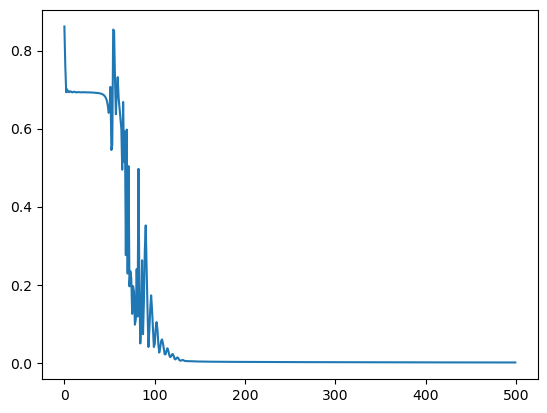

In [4]:
model = Transformer(embed_dim=8*5, num_heads=8, num_blocks=4, dropout_pbb=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

loss_epoch = []
for epoch in tqdm(range(500), ncols=100):
    optimizer.zero_grad()
    ypred = model.forward(time, flux)
    loss = criterion(ypred, y)
    loss.backward()
    optimizer.step()
    loss_epoch.append(loss.detach())

fig, ax = plt.subplots()
ax.plot(loss_epoch)

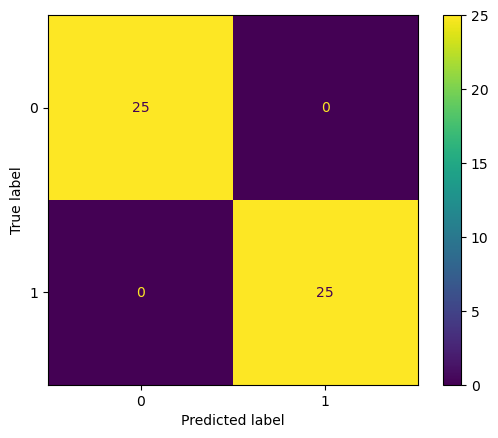

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_pred=ypred.argmax(dim=1), y_true=y);